In [51]:
from data.loader import load_query
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap
import xgboost as xgb
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, mean_squared_error, r2_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm

data = load_query("data/agg_games_with_moves__games.sql")

C:\Users\User\AppData\Local\Temp\ipykernel_76044\3974121534.py:19: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(
C:\Users\User\AppData\Local\Temp\ipykernel_76044\3974121534.py:37: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(


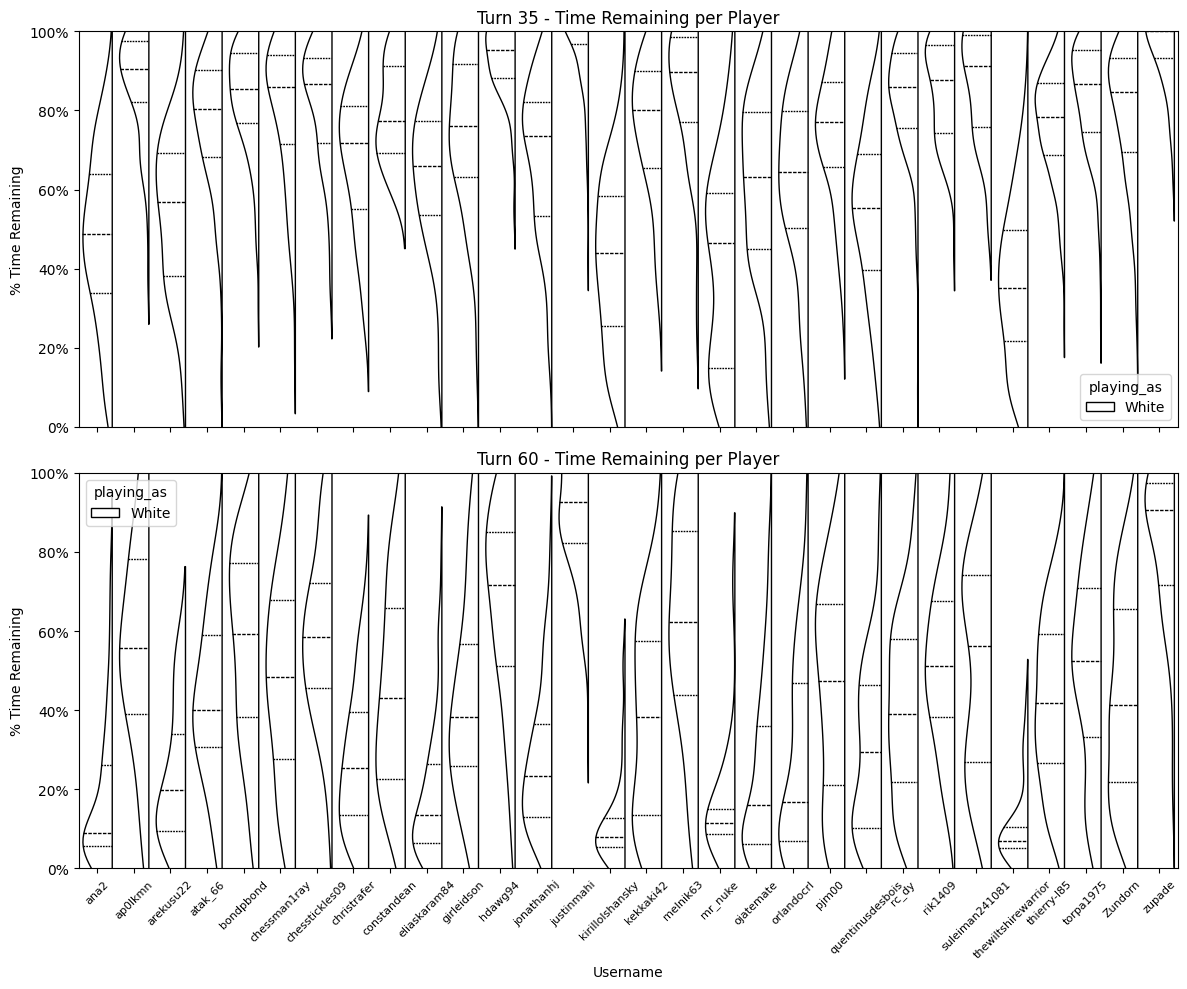

In [52]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

# Limit to top N players
top_players = (
    data['username']
    .value_counts()
    .head(30)
    .index
)

filtered_data = data[data['username'].isin(top_players)]
palette = {'White': 'white', 'Black': 'black'}

fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=True, sharey=True)

# Mid-game plot (top)
sns.violinplot(
    data=filtered_data,
    x='username',
    y='prct_time_remaining_mid',
    hue='playing_as',
    split=True,
    inner='quartile',
    scale='width',
    palette=palette,
    ax=axes[0],
    linewidth=1
)
axes[0].set_title('Turn 35 - Time Remaining per Player')
axes[0].set_ylabel('% Time Remaining')
axes[0].yaxis.set_major_formatter(PercentFormatter(xmax=1))
axes[0].tick_params(axis='x', labelbottom=False)  # Hide x-labels on top plot

# Late-game plot (bottom)
sns.violinplot(
    data=filtered_data,
    x='username',
    y='prct_time_remaining_late',  # <-- replace with actual column
    hue='playing_as',
    split=True,
    inner='quartile',
    scale='width',
    palette=palette,
    ax=axes[1],
    linewidth=1
)
axes[1].set_title('Turn 60 - Time Remaining per Player')
axes[1].set_xlabel('Username')
axes[1].set_ylabel('% Time Remaining')
axes[1].yaxis.set_major_formatter(PercentFormatter(xmax=1))
axes[1].tick_params(axis='x', labelrotation=45, labelsize=8)

# Tidy layout
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

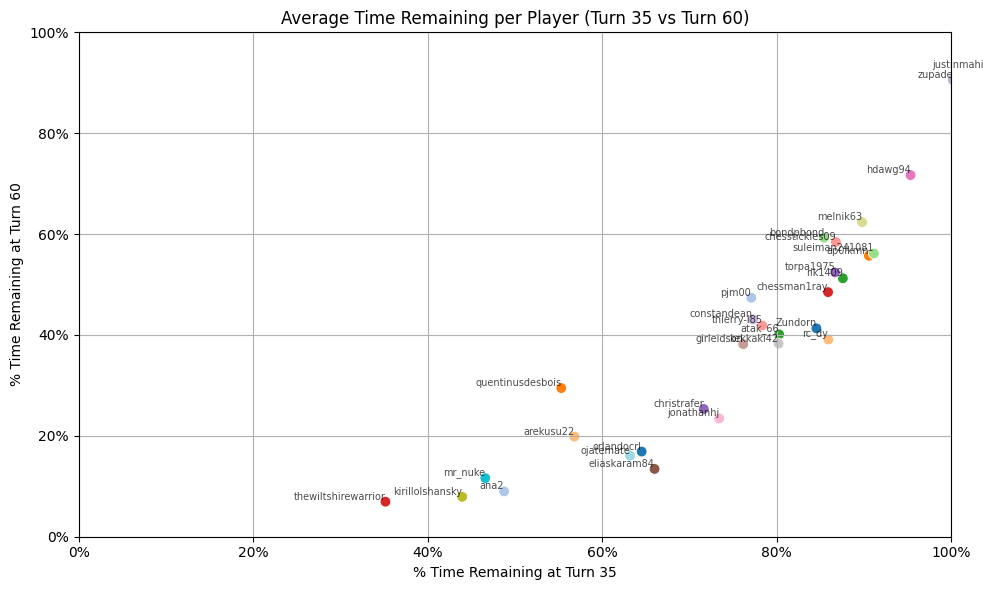

In [53]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

# Step 1: Get top players
top_players = (
    data['username']
    .value_counts()
    .head(30)
    .index
)

filtered_data = data[data['username'].isin(top_players)]

# Step 2: Compute average mid and late % time remaining per player
avg_data = filtered_data.groupby('username', as_index=False)[
    ['prct_time_remaining_mid', 'prct_time_remaining_late']
].median()

# Step 3: Scatter plot
plt.figure(figsize=(10, 6))

sns.scatterplot(
    data=avg_data,
    x='prct_time_remaining_mid',
    y='prct_time_remaining_late',
    hue='username',  # Optional: color by username
    palette='tab20',
    s=60,
    legend=False  # Set to True if you want a legend (may get cluttered)
)

# Annotate points with usernames
for i, row in avg_data.iterrows():
    plt.text(row['prct_time_remaining_mid'], row['prct_time_remaining_late'], row['username'],
             fontsize=7, ha='right', va='bottom', alpha=0.7)

# Axis formatting
plt.xlabel('% Time Remaining at Turn 35')
plt.ylabel('% Time Remaining at Turn 60')
plt.title('Average Time Remaining per Player (Turn 35 vs Turn 60)')
plt.gca().xaxis.set_major_formatter(PercentFormatter(xmax=1))
plt.gca().yaxis.set_major_formatter(PercentFormatter(xmax=1))
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.grid(True)
plt.tight_layout()
plt.show()


C:\Users\User\AppData\Local\Temp\ipykernel_76044\2167501993.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


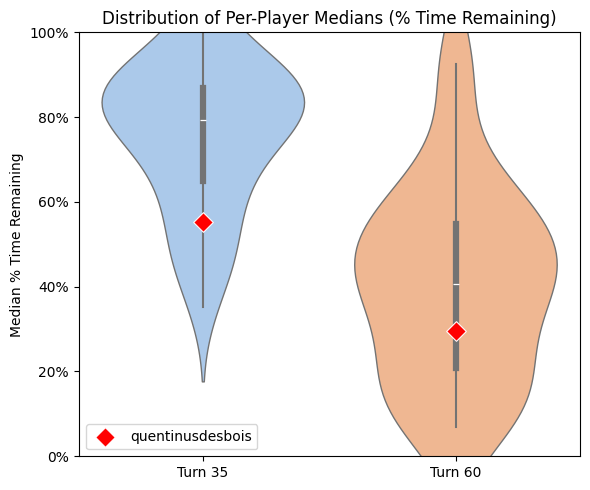

In [54]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import pandas as pd

# Set this to highlight any player you want
highlight_username = 'quentinusdesbois'  # ← Change this as needed

# Limit to top N players
top_players = (
    data['username']
    .value_counts()
    .head(30)
    .index
)

filtered_data = data[data['username'].isin(top_players)]

# Compute per-player medians
player_medians = (
    filtered_data
    .groupby('username')[['prct_time_remaining_mid', 'prct_time_remaining_late']]
    .median()
    .reset_index()
)

# Reshape to long format
melted = player_medians.melt(
    id_vars='username',
    var_name='stage',
    value_name='median_prct_time_remaining'
)

# Map column names to readable labels
stage_map = {
    'prct_time_remaining_mid': 'Turn 35',
    'prct_time_remaining_late': 'Turn 60'
}
melted['stage'] = melted['stage'].map(stage_map)

# Extract the highlighted user's values
highlight_points = melted[melted['username'] == highlight_username]

# Violin plot
plt.figure(figsize=(6, 5))
sns.violinplot(
    data=melted,
    x='stage',
    y='median_prct_time_remaining',
    inner='box',
    palette='pastel',
    linewidth=1
)

# Overlay highlighted user's values
if not highlight_points.empty:
    sns.scatterplot(
        data=highlight_points,
        x='stage',
        y='median_prct_time_remaining',
        color='red',
        s=100,
        marker='D',
        label=highlight_username,
        zorder=10
    )
    plt.legend()
else:
    print(f"⚠️ Username '{highlight_username}' not found in the top 30 players.")

# Final touches
plt.title('Distribution of Per-Player Medians (% Time Remaining)')
plt.ylabel('Median % Time Remaining')
plt.xlabel('')
plt.gca().yaxis.set_major_formatter(PercentFormatter(xmax=1))
plt.ylim(0, 1)
plt.tight_layout()
plt.show()


C:\Users\User\AppData\Local\Temp\ipykernel_76044\2520331893.py:59: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


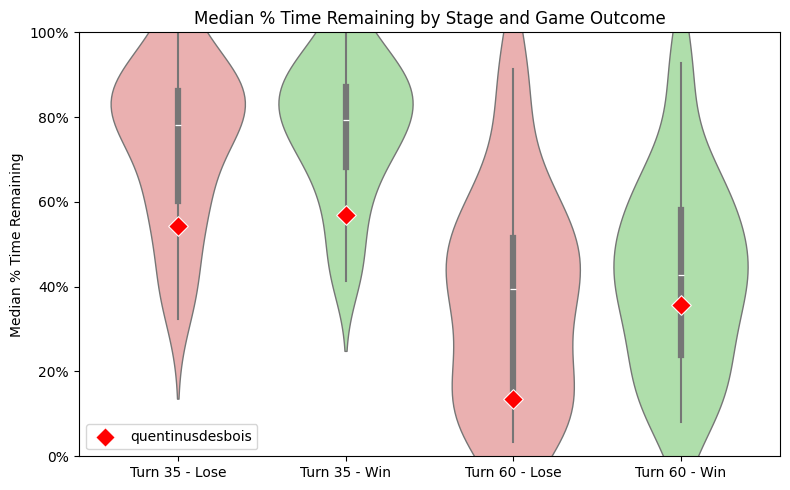

In [55]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import pandas as pd
from itertools import product

# Set this to highlight any player you want
highlight_username = 'quentinusdesbois'  # ← Change this as needed

# Filter to top 30 players
top_players = (
    data['username']
    .value_counts()
    .head(30)
    .index
)

# Filter relevant rows (Wins & Losses only)
filtered_data = data[
    data['username'].isin(top_players) &
    data['playing_result'].isin(['Win', 'Lose'])
]

# Compute per-player medians by username, result, and stage
player_medians = (
    filtered_data
    .groupby(['username', 'playing_result'])[
        ['prct_time_remaining_mid', 'prct_time_remaining_late']
    ]
    .median()
    .reset_index()
)

# Reshape for plotting
melted = player_medians.melt(
    id_vars=['username', 'playing_result'],
    var_name='stage',
    value_name='median_prct_time_remaining'
)

# Map internal column names to human-readable labels
stage_map = {
    'prct_time_remaining_mid': 'Turn 35',
    'prct_time_remaining_late': 'Turn 60'
}
melted['stage'] = melted['stage'].map(stage_map)

# Create combined x-axis label: 'Turn 35 - Win', etc.
melted['stage_result'] = melted['stage'] + ' - ' + melted['playing_result']

# Define color palette for each stage-result combination
stages = ['Turn 35', 'Turn 60']
results = ['Win', 'Lose']
base_colors = {'Win': '#A8E6A3', 'Lose': '#F4A6A6'}
palette = {f'{s} - {r}': base_colors[r] for s, r in product(stages, results)}

# Plot violin plot
plt.figure(figsize=(8, 5))
sns.violinplot(
    data=melted,
    x='stage_result',
    y='median_prct_time_remaining',
    inner='box',
    palette=palette,
    linewidth=1
)

# Highlight a specific player if found
highlight_points = melted[melted['username'] == highlight_username]
if not highlight_points.empty:
    sns.scatterplot(
        data=highlight_points,
        x='stage_result',
        y='median_prct_time_remaining',
        color='red',
        s=100,
        marker='D',
        label=highlight_username,
        zorder=10
    )
    plt.legend()
else:
    print(f"⚠️ Username '{highlight_username}' not found in the top 30 players or doesn't have both Win and Lose data.")

# Final plot formatting
plt.title('Median % Time Remaining by Stage and Game Outcome')
plt.ylabel('Median % Time Remaining')
plt.xlabel('')
plt.gca().yaxis.set_major_formatter(PercentFormatter(xmax=1))
plt.ylim(0, 1)
plt.tight_layout()
plt.show()
